In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

In [2]:
def andreev_potential(tau, varphi, Delta):
    return - Delta * np.sqrt(1 - tau * np.sin(varphi/2)** 2)

def tunnel(tau, varphi, Delta):
    return -(tau/4)*np.cos(varphi)+(tau/4-Delta)

def fourier_coefficient(k, tau, Delta, num_points=1000):
    """
    Computes the Fourier coefficient A_k for the potential U_tau(phi).
    
    Parameters:
        k (int): The Fourier mode.
        tau (float): The transmission coefficient (0 <= tau <= 1).
        delta (float): The superconducting gap.
        num_points (int): Number of integration points.
    
    Returns:
        float: The Fourier coefficient A_k.
    """
    integrand = lambda phi: andreev_potential(tau, phi, Delta) * np.cos(k * phi)
    A_k, _ = quad(integrand, 0, 2 * np.pi, limit=num_points)
    return A_k / np.pi

def compute_fourier_coefficients(tau, Delta, max_k):
    """
    Computes the Fourier coefficients A_k for k = 0, 1, ..., max_k.
    
    Parameters:
        tau (float): The transmission coefficient (0 <= tau <= 1).
        delta (float): The superconducting gap.
        max_k (int): Maximum Fourier mode to compute.
    
    Returns:
        list: Fourier coefficients [A_0, A_1, ..., A_max_k].
    """
    coefficients = []
    for k in range(max_k + 1):
        coefficients.append(fourier_coefficient(k, tau, Delta))
    return coefficients

In [3]:
def reconstructed_potential(phi, tau, Delta, max_k):
    potential = 0
    for k in range(max_k + 1):
        A_k = fourier_coefficient(k, tau, Delta)
        potential += A_k * np.cos(k * phi)
    return potential

In [29]:
tau_0 = 0.97
Delta_0 = 1

In [33]:
coefficients = compute_fourier_coefficients(tau=tau_0, Delta=Delta_0, max_k=3)

coefficients

[-1.324101467712276,
 -0.3858190463333126,
 0.06292702004378121,
 -0.02124803685087442]

In [34]:
varphi_range = np.linspace(-np.pi, np.pi, 100)

reconstructed_potential_values = [
    reconstructed_potential(phi, tau=tau_0, Delta=Delta_0, max_k=3) for phi in varphi_range
]

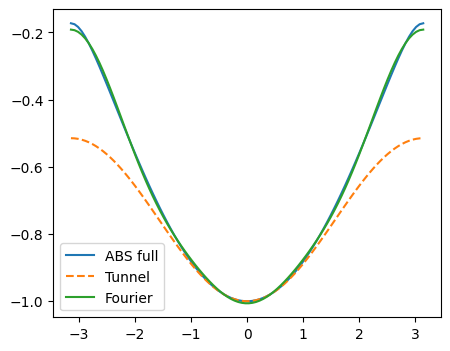

In [35]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(varphi_range, [andreev_potential(tau_0, varphi, 1) for varphi in varphi_range], label='ABS full')
ax.plot(varphi_range, [tunnel(tau_0, varphi, 1) for varphi in varphi_range], linestyle='--', label='Tunnel')
ax.plot(varphi_range, reconstructed_potential_values-np.array(coefficients[0])/2, label='Fourier')
ax.legend()